### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as ipw
from numpy.random import randn, rand
import scipy.io
import time
import statistics as stat
from functools import wraps

### Runtime

In [18]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [19]:
# Note that there are several shapes in the LASA Handwriting dataset

# name_of_dataset = 'Angle'
# name_of_dataset = 'CShape'
# name_of_dataset = 'GShape'
# name_of_dataset = 'JShape'
name_of_dataset = 'Sshape'

dataset = scipy.io.loadmat(name_of_dataset + '.mat')
#print(dataset)

# Unpack the trajectories and place into x and y used in learning step

#num_of_demos = dataset.demos

#size_of_state = size(dataset.demos{1}.pos,1);

#dim_of_function = size_of_state 

In [20]:
for i in range(1, num_of_demos):
    demo_struct = dataset.demos

num_of_points = x_train.shape[1]

# get time info for simulating the learnt system later
time_step = dataset.dt

len_of_dataseries = dataset.demos{1}.pos.shape[1]

time_series = np.cumsum()

num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
init_condition = stat.mean(init_position_of_demos[1])

SyntaxError: invalid syntax (2057862340.py, line 9)

#### Plot dataset (state trajectory with velocities as arrows)

In [ ]:
fig_dataset = plt.figure()
plt.style.use('default')
plt.title('Trajectory used in regression problem -' + name_of_dataset)
plt.plot(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Velocities'])

<Figure size 640x480 with 0 Axes>

### From notebook: vector_valued_with_rff

In [ ]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))


def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.reshape(y, (-1,1))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

### Random Fourier Features & Regression

In [ ]:
sigma = 5
num_of_samples = 50

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
lambda_ = 0.001 # regularization parameter lamda
alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x_train[:, i], w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func.T

#### Solve diff. equation using learnt model w. solver_ivp

In [ ]:
@runtime
[time_series, data_series] = solve_ivp(learnt_model, time_series, init_condition).y

### Plot simulated trajectory and streamslices for learnt model

In [ ]:
# Get lower and upper bound for plotting from dataset figure

lower_bound_x1 = fig_dataset.CurrentAxes.Xlim[0]
upper_bound_x1 = fig_dataset.CurrentAxes.XLim[1]
lower_bound_x2 = fig_dataset.CurrentAxes.YLim[0]
upper_bound_x2 = fig_dataset.CurrentAxes.YLim[1]

num_of_points = 17

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):

    # get velocities at each point with the learnt model
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[:,0]
    v_learnt[i,j] = Y_prime[:,1]

#### Combined solution and vector field for learnt model

NameError: name 'data_series' is not defined

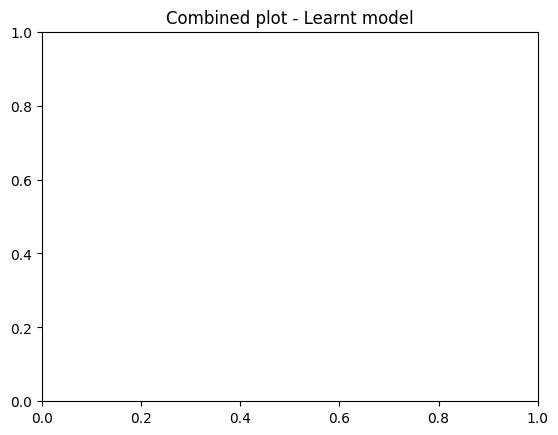

In [24]:
plt.figure()
plt.style.use('default')
plt.title('Combined plot - Learnt model')
plt.plot(data_series[:, 0], data_series[:, 1], '.', linewidth=1)
plt.streamplot(X1, X2, u_learnt, v_learnt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Streamlines'])
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])